In [358]:
# imporing packages
import seaborn
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [359]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


I use `RTX3070` as GPU device 

# Loading Dataset, Visualizing and Splitting

In [360]:
tensorShape = [100,100]
transforms = Compose([
                    ToTensor(),
                    Resize((tensorShape[0],tensorShape[1])),
                    # Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [361]:
dataset = ImageFolder('Shoe vs Sandal vs Boot Dataset', transform=transforms)

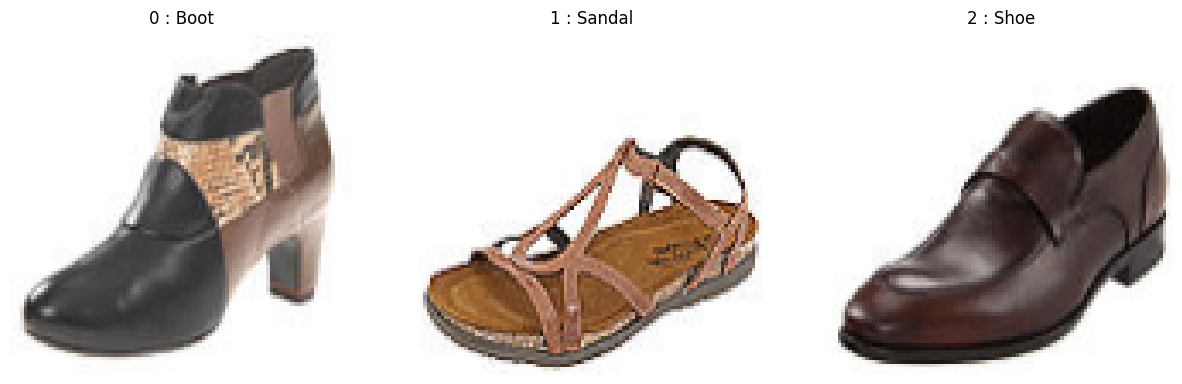

In [362]:
labels_map = {
    0: "Boot",
    1: "Sandal",
    2: "Shoe",
}
figure = plt.figure(figsize=(15, 10))
for i in range(3):
    index = np.random.randint(0,15000)
    while dataset.targets[index] != i:
        index = np.random.randint(0,15000)
    
    img, label = dataset[index]
    plt.subplot(1,3,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(str(label) + " : " + labels_map[label])
    plt.axis('off')
plt.show()


In [363]:
# split of 70% of all dataset for train
train_data, test_data = random_split(dataset, [int(0.7*len(dataset)), len(dataset) - int(0.7*len(dataset))])

In [364]:
# split of 20% of train dataset for validation
training_data, validation_data = random_split(train_data, [int(0.8*len(train_data)), len(train_data) - int(0.8*len(train_data))])

# A: MLP

### Build Model

In [365]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(

            nn.Linear(3*tensorShape[0]*tensorShape[1], 192),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(192, 96),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(96, 48),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(48, 12),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(12, 3),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.flatten(x.float())
        logits = self.linear_relu_stack(logits)
        y = self.softmax(logits)
        return y

* summary of model (number of parameters)

i design mlp model with 5 fully connected layer and 5.7 milion parameters. 

In [366]:
# Creating an instance of the class `NeuralNetwork` and moving it to device
model_mlp = MLP().to(device)
summary(model_mlp,(3,tensorShape[0],tensorShape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 30000]               0
            Linear-2                  [-1, 192]       5,760,192
              ReLU-3                  [-1, 192]               0
           Dropout-4                  [-1, 192]               0
            Linear-5                   [-1, 96]          18,528
              ReLU-6                   [-1, 96]               0
           Dropout-7                   [-1, 96]               0
            Linear-8                   [-1, 48]           4,656
              ReLU-9                   [-1, 48]               0
          Dropout-10                   [-1, 48]               0
           Linear-11                   [-1, 12]             588
             ReLU-12                   [-1, 12]               0
          Dropout-13                   [-1, 12]               0
           Linear-14                   

In [367]:
batchSize = 256

train_dataloader = DataLoader(training_data, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batchSize, shuffle=True)

In [368]:
crossEntropy = nn.CrossEntropyLoss()

### Training model & Optimization & TensorBoard

In [369]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    correct = 0
    model.train()
    for batch, (X, Y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        Y = Y.to(device)
        pred = model(X)
        loss = loss_fn(pred, Y)
        avgLoss += loss.item()
        correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    correct /= size
    avgLoss /= size
    print(f"\n -Training Accuracy = {(100*correct):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return correct, avgLoss

In [370]:
def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for X, Y in dataloader:
            # Compute prediction and loss
            X = X.to(device)
            Y = Y.to(device)
            pred = model(X)
            loss += loss_fn(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()

    loss /= size
    correct /= size
    print(f" -{error} Error: Accuracy = {(100*correct):>0.1f}%, Avg loss = {loss:>8f} \n")
    return correct, loss

In [371]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='MLP_Board')

epochs = 15
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model_mlp, crossEntropy, optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_mlp, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 1.098883  [    0/ 8400]
loss: 1.089538  [ 2560/ 8400]
loss: 1.094952  [ 5120/ 8400]
loss: 1.112103  [ 7680/ 8400]

 -Training Accuracy = 34.8%, Avg loss = 0.004328 

 -Validation Error: Accuracy = 34.9%, Avg loss = 0.004685 

Epoch 2
-------------------------------
loss: 1.096239  [    0/ 8400]
loss: 1.099596  [ 2560/ 8400]
loss: 1.082148  [ 5120/ 8400]
loss: 1.093993  [ 7680/ 8400]

 -Training Accuracy = 37.6%, Avg loss = 0.004288 

 -Validation Error: Accuracy = 60.3%, Avg loss = 0.004609 

Epoch 3
-------------------------------
loss: 1.100270  [    0/ 8400]
loss: 1.070829  [ 2560/ 8400]
loss: 1.080965  [ 5120/ 8400]
loss: 1.058273  [ 7680/ 8400]

 -Training Accuracy = 41.5%, Avg loss = 0.004221 

 -Validation Error: Accuracy = 61.2%, Avg loss = 0.004504 

Epoch 4
-------------------------------
loss: 1.053293  [    0/ 8400]
loss: 1.061315  [ 2560/ 8400]
loss: 1.043172  [ 5120/ 8400]
loss: 1.035733  [ 7680/ 8400]

 -Training Accuracy = 4

### Test and Result

* accuracy and loss for Test Dataset

In [372]:
test_loop(test_dataloader, model_mlp, crossEntropy, 'Test');

 -Test Error: Accuracy = 79.9%, Avg loss = 0.003104 



In [373]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and losss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_mlp(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [374]:
# classification report
print(classification_report(y_true=y_true, 
                            y_pred=y_pred,
                            target_names=['Boot','Sandal','Shoe']))

              precision    recall  f1-score   support

        Boot       0.83      0.93      0.88      1513
      Sandal       0.84      0.61      0.71      1520
        Shoe       0.74      0.86      0.80      1467

    accuracy                           0.80      4500
   macro avg       0.80      0.80      0.79      4500
weighted avg       0.80      0.80      0.79      4500



* confusion matrix

In [375]:
# Creating confusion matrix
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[1408   31   74]
 [ 231  928  361]
 [  63  144 1260]]


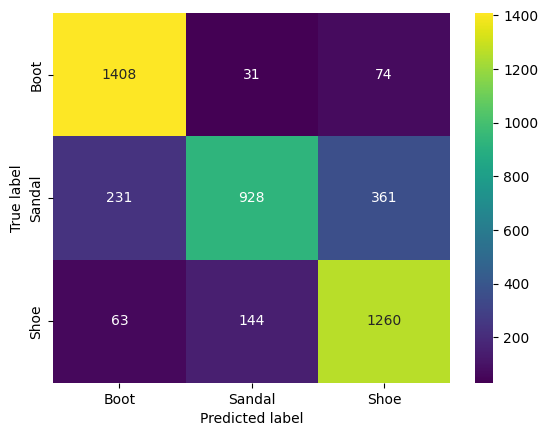

In [376]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Boot','Sandal','Shoe'], yticklabels=['Boot','Sandal','Shoe'], cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [377]:
torch.save(model_mlp.state_dict(), 'model_mlp.pth')

# B: CNN

### Build Model

In [378]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3,16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(16),

            nn.Dropout(0.5),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),

            nn.Dropout(0.5),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(1,1),
            nn.BatchNorm2d(64),
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(

            nn.Dropout(0.5),
            nn.Linear(64*25*25, 128),
            nn.ReLU(),

            nn.Linear(128, 3),
            nn.ReLU(),
            
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        features = self.features(x.float())
        flatten = self.flatten(features)
        logits = self.classifier(flatten)
        y = self.softmax(logits)
        return y

* number of parameters

i design cnn model with 3 conv layer and 2 fully connected layer and 5.1 milion parameters. 

In [379]:
# Creating an instance of the class `NeuralNetwork` and moving it to device
model_cnn = CNN().to(device)
summary(model_cnn,(3,tensorShape[0],tensorShape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             448
              ReLU-2         [-1, 16, 100, 100]               0
         MaxPool2d-3           [-1, 16, 50, 50]               0
       BatchNorm2d-4           [-1, 16, 50, 50]              32
           Dropout-5           [-1, 16, 50, 50]               0
            Conv2d-6           [-1, 32, 50, 50]           4,640
              ReLU-7           [-1, 32, 50, 50]               0
         MaxPool2d-8           [-1, 32, 25, 25]               0
       BatchNorm2d-9           [-1, 32, 25, 25]              64
          Dropout-10           [-1, 32, 25, 25]               0
           Conv2d-11           [-1, 64, 25, 25]          18,496
             ReLU-12           [-1, 64, 25, 25]               0
        MaxPool2d-13           [-1, 64, 25, 25]               0
      BatchNorm2d-14           [-1, 64,

### Training model & Optimization & Result (TensorBoard)

In [380]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='CNN_Board')

epochs = 20
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model_cnn, crossEntropy, optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_cnn, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 1.101432  [    0/ 8400]
loss: 0.793275  [ 2560/ 8400]
loss: 0.719679  [ 5120/ 8400]
loss: 0.696029  [ 7680/ 8400]

 -Training Accuracy = 78.2%, Avg loss = 0.003048 

 -Validation Error: Accuracy = 73.0%, Avg loss = 0.003585 

Epoch 2
-------------------------------
loss: 0.678198  [    0/ 8400]
loss: 0.675680  [ 2560/ 8400]
loss: 0.675185  [ 5120/ 8400]
loss: 0.663509  [ 7680/ 8400]

 -Training Accuracy = 89.1%, Avg loss = 0.002604 

 -Validation Error: Accuracy = 81.2%, Avg loss = 0.003162 

Epoch 3
-------------------------------
loss: 0.623246  [    0/ 8400]
loss: 0.642511  [ 2560/ 8400]
loss: 0.638197  [ 5120/ 8400]
loss: 0.656006  [ 7680/ 8400]

 -Training Accuracy = 90.7%, Avg loss = 0.002540 

 -Validation Error: Accuracy = 86.6%, Avg loss = 0.002938 

Epoch 4
-------------------------------
loss: 0.640407  [    0/ 8400]
loss: 0.633714  [ 2560/ 8400]
loss: 0.671802  [ 5120/ 8400]
loss: 0.611306  [ 7680/ 8400]

 -Training Accuracy = 9

### Test and Result

* accuracy and loss

In [381]:
# cnn model
test_loop(test_dataloader, model_cnn, crossEntropy, 'Test');

 -Test Error: Accuracy = 95.2%, Avg loss = 0.002401 



In [382]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and loss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_cnn(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [383]:
# classification report for cnn model
print(classification_report(y_true=y_true, 
                            y_pred=y_pred,
                            target_names=['Boot','Sandal','Shoe']))

              precision    recall  f1-score   support

        Boot       0.96      0.97      0.96      1513
      Sandal       0.96      0.94      0.95      1520
        Shoe       0.93      0.95      0.94      1467

    accuracy                           0.95      4500
   macro avg       0.95      0.95      0.95      4500
weighted avg       0.95      0.95      0.95      4500



* confusion matrix

In [384]:
# Creating confusion matrix for cnn model
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[1461   19   33]
 [  25 1424   71]
 [  31   37 1399]]


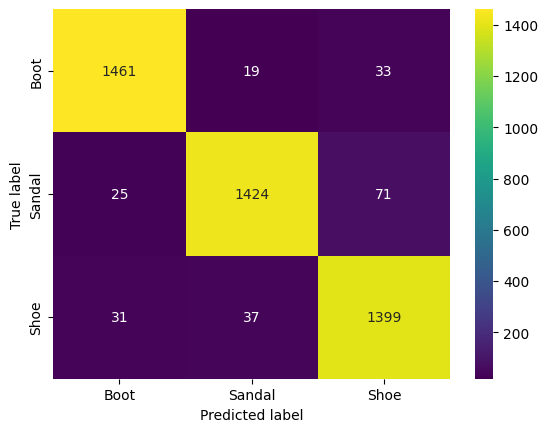

In [385]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Boot','Sandal','Shoe'], yticklabels=['Boot','Sandal','Shoe'], cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [386]:
torch.save(model_cnn.state_dict(), 'model_cnn.pth')

# Comparing MLP and CNN
> Both `MLP` and `CNN` can be used for Image classification, however `MLP` takes `vectors` as inputs and `CNN` takes `tensors` as inputs. CNN is better at understanding `spatial relationships` (relationships between nearby pixels of an image) between pixels of an image, so ***CNN will perform better for complex images than MLP***. We can see that CNN receives an accuracy of more than 93%(sometimes 90%), whereas MLP receives an accuracy of less than . Additionally, ***CNN converges faster than MLP.***

# C: CNN with DropBlock

### DropBlock 

In [387]:
import torch.nn.functional as F
from torch import Tensor

class DropBlock(nn.Module):
    def __init__(self, blockSize: int, p: float = 0.5):
        super().__init__()
        self.blockSize = blockSize
        self.kernelSize = (self.blockSize, self.blockSize)
        self.stride = (1, 1)
        self.padding = (self.blockSize // 2, self.blockSize // 2)
        self.p = p


    def gammCalculation(self, x: Tensor) -> float:
        invalid = (1 - self.p) / (self.blockSize ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.blockSize + 1) ** 2)
        return invalid * valid


    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            mask = torch.bernoulli(torch.ones_like(x) * self.gammCalculation(x))
            maskBlock = 1 - F.max_pool2d(mask,kernel_size=self.kernelSize,stride=self.stride,padding=self.padding)
            x *= maskBlock * (maskBlock.numel() / maskBlock.sum())
        return x

> * Reference: https://towardsdatascience.com/a-better-dropout-implementing-dropblock-in-pytorch-50d19d1bc59a

### Build Model

In [388]:
class CNN_dropBlock(nn.Module):
    def __init__(self):
        super(CNN_dropBlock, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3,16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(16),

            DropBlock(blockSize=7,p=0.5),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),

            DropBlock(blockSize=3,p=0.5),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(1,1),
            nn.BatchNorm2d(64),
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(

            nn.Dropout(0.5),
            nn.Linear(64*25*25, 128),
            nn.ReLU(),

            nn.Linear(128, 3),
            nn.ReLU(),
            
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        features = self.features(x.float())
        flatten = self.flatten(features)
        logits = self.classifier(flatten)
        y = self.softmax(logits)
        return y

In [389]:
# Creating an instance of the class `NeuralNetwork` and moving it to device
model_cnn_dropBlock = CNN_dropBlock().to(device)
summary(model_cnn_dropBlock,(3,tensorShape[0],tensorShape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             448
              ReLU-2         [-1, 16, 100, 100]               0
         MaxPool2d-3           [-1, 16, 50, 50]               0
       BatchNorm2d-4           [-1, 16, 50, 50]              32
         DropBlock-5           [-1, 16, 50, 50]               0
            Conv2d-6           [-1, 32, 50, 50]           4,640
              ReLU-7           [-1, 32, 50, 50]               0
         MaxPool2d-8           [-1, 32, 25, 25]               0
       BatchNorm2d-9           [-1, 32, 25, 25]              64
        DropBlock-10           [-1, 32, 25, 25]               0
           Conv2d-11           [-1, 64, 25, 25]          18,496
             ReLU-12           [-1, 64, 25, 25]               0
        MaxPool2d-13           [-1, 64, 25, 25]               0
      BatchNorm2d-14           [-1, 64,

### Training model & Optimization & Result (TensorBoard)

In [390]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='CNN_dropBlock_Board')

epochs = 20
optimizer = torch.optim.Adam(model_cnn_dropBlock.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model_cnn_dropBlock, crossEntropy, optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_cnn_dropBlock, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 1.102811  [    0/ 8400]
loss: 0.785051  [ 2560/ 8400]
loss: 0.723968  [ 5120/ 8400]
loss: 0.730565  [ 7680/ 8400]

 -Training Accuracy = 76.6%, Avg loss = 0.003099 

 -Validation Error: Accuracy = 56.4%, Avg loss = 0.004100 

Epoch 2
-------------------------------
loss: 0.738955  [    0/ 8400]
loss: 0.702779  [ 2560/ 8400]
loss: 0.676283  [ 5120/ 8400]
loss: 0.691130  [ 7680/ 8400]

 -Training Accuracy = 86.3%, Avg loss = 0.002712 

 -Validation Error: Accuracy = 75.7%, Avg loss = 0.003384 

Epoch 3
-------------------------------
loss: 0.691168  [    0/ 8400]
loss: 0.701846  [ 2560/ 8400]
loss: 0.679947  [ 5120/ 8400]
loss: 0.662813  [ 7680/ 8400]

 -Training Accuracy = 87.9%, Avg loss = 0.002639 

 -Validation Error: Accuracy = 82.7%, Avg loss = 0.003122 

Epoch 4
-------------------------------
loss: 0.697860  [    0/ 8400]
loss: 0.667787  [ 2560/ 8400]
loss: 0.653698  [ 5120/ 8400]
loss: 0.667822  [ 7680/ 8400]

 -Training Accuracy = 8

### Test and Result

* accuracy and loss

In [391]:
# cnn model
test_loop(test_dataloader, model_cnn_dropBlock, crossEntropy, 'Test');

 -Test Error: Accuracy = 91.5%, Avg loss = 0.002532 



In [392]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and loss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_cnn_dropBlock(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [393]:
# classification report for cnn model
print(classification_report(y_true=y_true, 
                            y_pred=y_pred,
                            target_names=['Boot','Sandal','Shoe']))

              precision    recall  f1-score   support

        Boot       0.86      0.99      0.92      1513
      Sandal       0.97      0.83      0.90      1520
        Shoe       0.93      0.93      0.93      1467

    accuracy                           0.91      4500
   macro avg       0.92      0.92      0.91      4500
weighted avg       0.92      0.91      0.91      4500



* confusion matrix

In [394]:
# Creating confusion matrix for cnn model
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[1496    8    9]
 [ 174 1259   87]
 [  79   26 1362]]


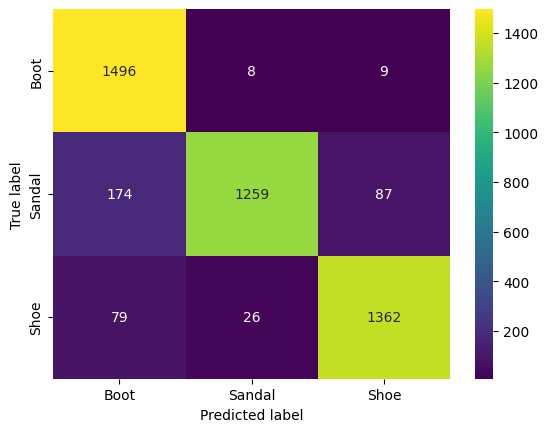

In [395]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Boot','Sandal','Shoe'], yticklabels=['Boot','Sandal','Shoe'], cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [396]:
torch.save(model_cnn_dropBlock.state_dict(), 'model_cnn_dropBlock.pth')

### 
> When the features are correlated, even with dropout, information about the input can still be sent to the next layer, which causes the networks to overfit. DropBlock is a structured form of dropout, that is particularly effective to regularize convolutional networks. In DropBlock, features in a block, i.e., a contiguous region of a feature map, are dropped together. As DropBlock discards features in a correlated area, the networks must look elsewhere for evidence to fit the data. As a result, it helps the network to avoid overfitting(we can see from resualt in B vs C)

> * `Reference` : Golnaz Ghiasi, Tsung-Yi Lin, Quoc V. Le. ***DropBlock: A regularization method for convolutional networks***

# D: CNN with Factorization

### Build Model

In [397]:
class CNN_factorization(nn.Module):
    def __init__(self):
        super(CNN_factorization, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3,16,kernel_size=(1,3),padding=(0,1)),
            nn.Conv2d(16,16,kernel_size=(3,1),padding=(1,0)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(16),

            DropBlock(blockSize=7,p=0.5),
            nn.Conv2d(16,32,kernel_size=(1,3),padding=(0,1)),
            nn.Conv2d(32,32,kernel_size=(3,1),padding=(1,0)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),

            DropBlock(blockSize=3,p=0.5),
            nn.Conv2d(32,64,kernel_size=(1,3),padding=(0,1)),
            nn.Conv2d(64,64,kernel_size=(3,1),padding=(1,0)),
            nn.ReLU(),
            nn.MaxPool2d(1,1),
            nn.BatchNorm2d(64),
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(

            nn.Dropout(0.5),
            nn.Linear(64*25*25, 128),
            nn.ReLU(),

            nn.Linear(128, 3),
            nn.ReLU(),
            
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        features = self.features(x.float())
        flatten = self.flatten(features)
        logits = self.classifier(flatten)
        y = self.softmax(logits)
        return y

In [398]:
# Creating an instance of the class `NeuralNetwork` and moving it to device
model_cnn_factorization = CNN_factorization().to(device)
summary(model_cnn_factorization,(3,tensorShape[0],tensorShape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             160
            Conv2d-2         [-1, 16, 100, 100]             784
              ReLU-3         [-1, 16, 100, 100]               0
         MaxPool2d-4           [-1, 16, 50, 50]               0
       BatchNorm2d-5           [-1, 16, 50, 50]              32
         DropBlock-6           [-1, 16, 50, 50]               0
            Conv2d-7           [-1, 32, 50, 50]           1,568
            Conv2d-8           [-1, 32, 50, 50]           3,104
              ReLU-9           [-1, 32, 50, 50]               0
        MaxPool2d-10           [-1, 32, 25, 25]               0
      BatchNorm2d-11           [-1, 32, 25, 25]              64
        DropBlock-12           [-1, 32, 25, 25]               0
           Conv2d-13           [-1, 64, 25, 25]           6,208
           Conv2d-14           [-1, 64,

### Training model & Optimization & Result (TensorBoard)

In [399]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='CNN_factorization_Board')

epochs = 20
optimizer = torch.optim.Adam(model_cnn_factorization.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model_cnn_factorization, crossEntropy, optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_cnn_factorization, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 1.094762  [    0/ 8400]
loss: 0.782857  [ 2560/ 8400]
loss: 0.717017  [ 5120/ 8400]
loss: 0.714798  [ 7680/ 8400]

 -Training Accuracy = 77.9%, Avg loss = 0.003042 

 -Validation Error: Accuracy = 32.9%, Avg loss = 0.004910 

Epoch 2
-------------------------------
loss: 0.667002  [    0/ 8400]
loss: 0.703916  [ 2560/ 8400]
loss: 0.675440  [ 5120/ 8400]
loss: 0.671335  [ 7680/ 8400]

 -Training Accuracy = 88.4%, Avg loss = 0.002622 

 -Validation Error: Accuracy = 68.8%, Avg loss = 0.003610 

Epoch 3
-------------------------------
loss: 0.656834  [    0/ 8400]
loss: 0.641337  [ 2560/ 8400]
loss: 0.645579  [ 5120/ 8400]
loss: 0.642229  [ 7680/ 8400]

 -Training Accuracy = 90.2%, Avg loss = 0.002554 

 -Validation Error: Accuracy = 89.5%, Avg loss = 0.002864 

Epoch 4
-------------------------------
loss: 0.641131  [    0/ 8400]
loss: 0.654442  [ 2560/ 8400]
loss: 0.633919  [ 5120/ 8400]
loss: 0.636047  [ 7680/ 8400]

 -Training Accuracy = 9

### Test and Result

* accuracy and loss

In [400]:
# cnn model
test_loop(test_dataloader, model_cnn_factorization, crossEntropy, 'Test');

 -Test Error: Accuracy = 93.1%, Avg loss = 0.002468 



In [401]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and loss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_cnn_factorization(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [402]:
# classification report for cnn model
print(classification_report(y_true=y_true, 
                            y_pred=y_pred,
                            target_names=['Boot','Sandal','Shoe']))

              precision    recall  f1-score   support

        Boot       0.89      1.00      0.94      1513
      Sandal       0.98      0.86      0.91      1520
        Shoe       0.94      0.94      0.94      1467

    accuracy                           0.93      4500
   macro avg       0.94      0.93      0.93      4500
weighted avg       0.94      0.93      0.93      4500



* confusion matrix

In [403]:
# Creating confusion matrix for cnn model
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[1506    3    4]
 [ 133 1303   84]
 [  61   24 1382]]


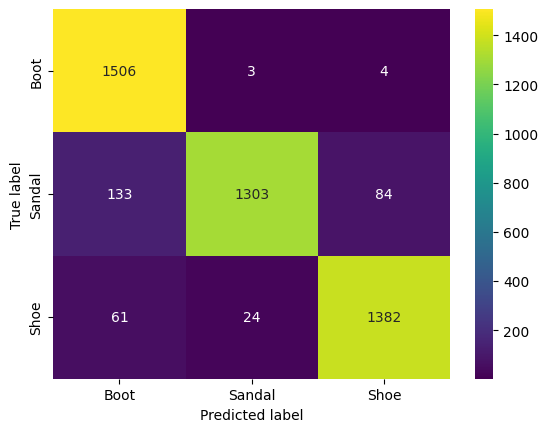

In [404]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Boot','Sandal','Shoe'], yticklabels=['Boot','Sandal','Shoe'], cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [405]:
torch.save(model_cnn_factorization.state_dict(), 'model_cnn_factorization.pth')

### Number of parameters 
> As a result of kernel factorization, the number of parameters is reduced by about (5,144,915 - 5,144,323 = 592) but the value reduced is very small; most of the reduced value lies in fully connected layers. also if the input and output channel of a convolutional layer is very distant the number of parameters will increase.

### Advantages
> - Accelerating network training
> - Reduce number of parameters and size of model
> - Reduce Avg Loss